<a href="https://colab.research.google.com/github/shebogholo/pytorch/blob/master/CNN_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline


# check if CUDA is available
if torch.cuda.is_available():
  print('CUDA is available!  Training on GPU')
else:
    print('CUDA is not available.  Training on CPU')

CUDA is available!  Training on GPU


In [2]:
# Hyper-parameters
num_workers = 0
batch_size = 20

# validation size
valid_size = 0.2

# data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# training and test data
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

# obtain indices for training and validation data
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# training and validation sampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# create data loaders for training, validation and test data
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=train_sampler, 
                                           num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=valid_sampler, 
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

# image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


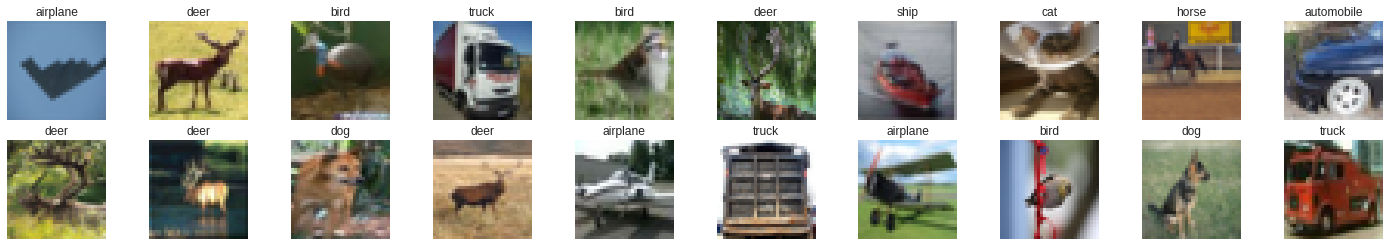

In [3]:
# unnormalize and display image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
images, labels = next(iter(train_loader))
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

num_display_images = 20  # number of images to display
for idx in np.arange(num_display_images):
    ax = fig.add_subplot(2, num_display_images/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
# Network Architecture (CNN)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # (32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        # (16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # (8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        
        # (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        
        # dropout probability 0.50
        self.dropout = nn.Dropout(0.50)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten input image
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(x)
        
        # add first hidden layer, with relu
        x = F.relu(self.fc1(x))
        
        # add dropout layer
        x = self.dropout(x)
        
        return self.fc2(x)

# intantiate CNNModel
model = CNNModel()

# if GPU is available, move tensors to GPU
if torch.cuda.is_available():
    model.cuda()

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [6]:
%%time
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

print('Training start...')
print('*' * 62)
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
       
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        loss.backward()
        
        # update model parameters
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)
         
    # validate the model
    model.eval()
    for data, target in valid_loader:
      
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
      
        output = model(data)

        loss = criterion(output, target)
        
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
      
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'cifar10_model.pt')
        valid_loss_min = valid_loss

Training start...
**************************************************************
Epoch: 1 	Training Loss: 1.703 	Validation Loss: 0.370
Epoch: 2 	Training Loss: 1.390 	Validation Loss: 0.315
Epoch: 3 	Training Loss: 1.262 	Validation Loss: 0.288
Epoch: 4 	Training Loss: 1.175 	Validation Loss: 0.268
Epoch: 5 	Training Loss: 1.106 	Validation Loss: 0.250
Epoch: 6 	Training Loss: 1.055 	Validation Loss: 0.242
Epoch: 7 	Training Loss: 1.010 	Validation Loss: 0.227
Epoch: 8 	Training Loss: 0.966 	Validation Loss: 0.216
Epoch: 9 	Training Loss: 0.929 	Validation Loss: 0.212
Epoch: 10 	Training Loss: 0.891 	Validation Loss: 0.201
Epoch: 11 	Training Loss: 0.863 	Validation Loss: 0.191
Epoch: 12 	Training Loss: 0.832 	Validation Loss: 0.185
Epoch: 13 	Training Loss: 0.806 	Validation Loss: 0.179
Epoch: 14 	Training Loss: 0.781 	Validation Loss: 0.177
Epoch: 15 	Training Loss: 0.766 	Validation Loss: 0.169
Epoch: 16 	Training Loss: 0.744 	Validation Loss: 0.170
Epoch: 17 	Training Loss: 0.725 

In [0]:
model.load_state_dict(torch.load('cifar10_model.pt'))

In [8]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:

    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
        
    output = model(data)

    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)    
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.3f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), 
            np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest accuracy: %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), 
    np.sum(class_total)))

Test Loss: 0.794

Test Accuracy of airplane: 74% (742/1000)
Test Accuracy of automobile: 85% (857/1000)
Test Accuracy of  bird: 61% (618/1000)
Test Accuracy of   cat: 56% (564/1000)
Test Accuracy of  deer: 72% (722/1000)
Test Accuracy of   dog: 59% (599/1000)
Test Accuracy of  frog: 86% (863/1000)
Test Accuracy of horse: 70% (709/1000)
Test Accuracy of  ship: 86% (861/1000)
Test Accuracy of truck: 78% (783/1000)

Test accuracy: 73% (7318/10000)


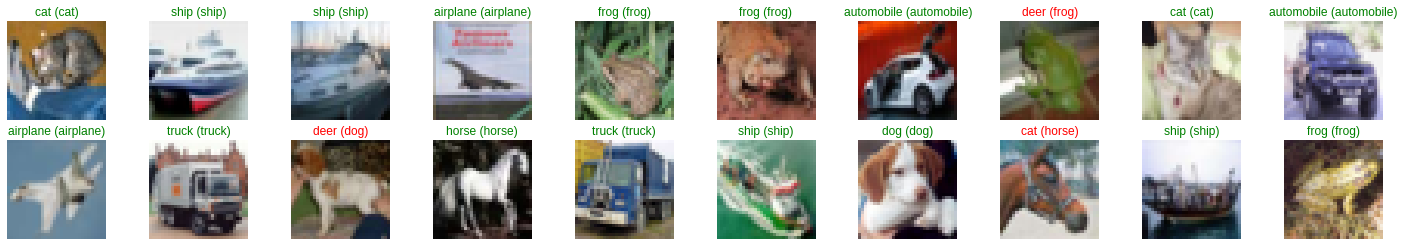

In [9]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images.numpy()

if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model(images)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red"))